In [8]:
# Load a full run (model + predictor + loaders + splits) for evaluation
import os, sys, torch
from torch_geometric.transforms import ToUndirected

PROJECT_ROOT = os.path.abspath("..")  # if notebook is in notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.load_graph_data import load_hetero_pt
from src.model_io import load_full_run

# Device selection (prefer CUDA; fall back to CPU to avoid MPS sampler issues)
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    # MPS missing CSR conversion for LinkNeighborLoader; use CPU for reliability
    os.environ.setdefault('PYTORCH_ENABLE_MPS_FALLBACK', '1')
    DEVICE = torch.device("cpu")
print('Using device:', DEVICE)

MODEL_SAVE_NAME = 'best_model.pt'

# Load and preprocess data (keep consistent with training)
data = load_hetero_pt()
data = ToUndirected()(data)

# Optional: drop nodes/edges to mirror training pipeline
# Which node types do we want to KEEP in the graph?
keep = ['email', 'sender', 'url', 'domain', 'stem', 'body_cluster']     # <- adjust as you like

keep_set = set(keep)

# 1) Delete node types that are NOT in keep
for ntype in list(data.node_types):   # list(...) so we can modify while iterating
    if ntype not in keep_set:
        del data[ntype]

# 2) Delete edge types whose src or dst is NOT in keep
for et in list(data.edge_types):      # et is (src, rel, dst)
    src, rel, dst = et
    if src not in keep_set or dst not in keep_set:
        del data[et]


# Load model, predictor, loaders, splits, and checkpoint metadata
model, predictor, loaders, splits, checkpoint = load_full_run(
    data=data,
    device=DEVICE,
    filename=MODEL_SAVE_NAME,
)
print(f"Loaded checkpoint from epoch {checkpoint['epoch']} with val loss {checkpoint['val_loss']:.4f}")

Using device: cpu


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/load_graph_data.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_l

Loaded checkpoint from epoch 27 with val loss 0.8563


In [9]:
from src.embed import embed_with_graph
import torch.nn.functional as F

train_graph = splits['train_graph']

h_train = embed_with_graph(DEVICE, model, train_graph)
email_vecs = F.normalize(h_train['email'], p=2, dim=1).cpu().numpy()  # ensure unit norm + CPU

import hdbscan
import numpy as np

from sklearn.cluster import DBSCAN
import numpy as np

# Define a range of epsilon values to test
# epsilon_values = [0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.065, 0.07, 0.08, 0.09]



# print("DBSCAN Clustering with different epsilon values:")
# for eps in epsilon_values:
#     clusterer = DBSCAN(eps=eps, min_samples=5, metric='euclidean')
#     labels = clusterer.fit_predict(email_vecs)
#     n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise = np.sum(labels == -1)
#     print(f"ε = {eps:<4} → Clusters: {n_clusters:<3} | Noise points: {n_noise}")



In [49]:
# import numpy as np

# # Mapping 1: cluster_label → list of email ids
# cluster_to_email = {}
# for idx, label in enumerate(labels):
#     if label not in cluster_to_email:
#         cluster_to_email[label] = []
#     cluster_to_email[label].append(idx)  # idx is email node id

# # Mapping 2: email id → embedding
# email_to_embedding = {idx: vec for idx, vec in enumerate(email_vecs)}

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def visualize_email_clusters(email_vecs, labels, max_points=5000):
    """Project embeddings to 2D and show cluster summary + scatter plot."""
    labels = np.asarray(labels)
    email_vecs = np.asarray(email_vecs)
    # Downsample for plotting
    if len(email_vecs) > max_points:
        idx = np.random.choice(len(email_vecs), size=max_points, replace=False)
        vecs_plot = email_vecs[idx]
        labels_plot = labels[idx]
    else:
        vecs_plot = email_vecs
        labels_plot = labels
    # Dimensionality reduction
    try:
        import umap
        reducer = umap.UMAP(n_components=2, random_state=42)
        coords = reducer.fit_transform(vecs_plot)
    except Exception:
        from sklearn.decomposition import PCA
        coords = PCA(n_components=2).fit_transform(vecs_plot)
    # Summary stats (exclude noise)
    mask = labels >= 0
    non_noise = labels[mask]
    n_clusters = len(set(non_noise))
    noise_count = int((labels == -1).sum())
    sizes = Counter(non_noise)
    largest = max(sizes.values()) if sizes else 0
    avg_size = float(np.mean(list(sizes.values()))) if sizes else 0.0
    print("📊 Clustering Summary:")
    print(f" - Number of clusters (excluding noise): {n_clusters}")
    print(f" - Number of noise emails: {noise_count}")
    print(f" - Average cluster size: {avg_size:.2f}")
    print(f" - Largest cluster size: {largest}")
    # Scatter plot
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(coords[:,0], coords[:,1], c=labels_plot, cmap='tab20', s=5, alpha=0.7)
    plt.title('Email Embeddings (2D projection)')
    plt.xticks([]); plt.yticks([])
    plt.show()


/Users/mcandersyo/.venv-pyg/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcandersyo/.venv-pyg/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/mcandersyo/.venv-pyg/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


📊 Clustering Summary:
 - Number of clusters (excluding noise): 73
 - Number of noise emails: 12358
 - Average cluster size: 218.45
 - Largest cluster size: 4037


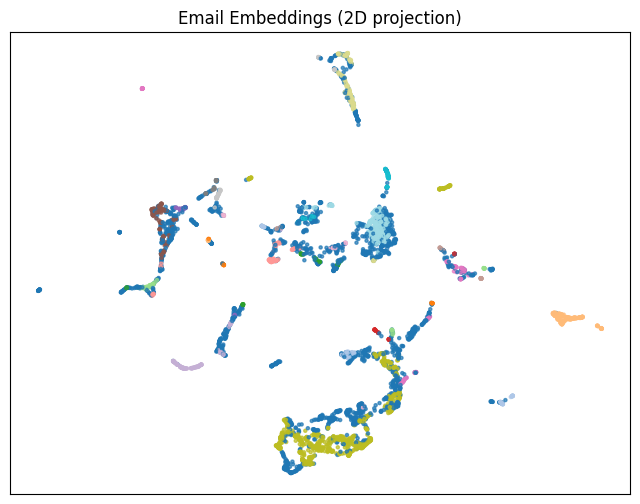

In [11]:
import hdbscan

# Final clustering with chosen params
clusterer = hdbscan.HDBSCAN(min_cluster_size=40, min_samples=20, metric='euclidean')
labels = clusterer.fit_predict(email_vecs)

# Now visualize using the current labels
visualize_email_clusters(email_vecs, labels)


In [12]:
from pathlib import Path
import json
import sys
import pandas as pd

# Load email metadata and CSV rows for cluster previews
REPO_ROOT = Path(PROJECT_ROOT).resolve().parent.parent
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

from core.graph.common import parse_misp_events

misp_candidates = [
    REPO_ROOT / 'data' / 'misp' / 'trec07_misp.json',
    REPO_ROOT / 'data' / 'misp' / 'TREC-07-misp.json',
]
csv_path = REPO_ROOT / 'data' / 'csv' / 'TREC-07.csv'
meta_path = REPO_ROOT / 'core' / 'results' / 'TREC-07-misp_hetero.meta.json'

n_email_nodes = int(getattr(email_vecs, 'shape', [len(email_vecs)])[0])
email_records = []
raw_events = []
src_path = None
for cand in misp_candidates:
    if not cand.exists():
        continue
    with cand.open() as f:
        events = json.load(f)
    if len(events) == n_email_nodes:
        raw_events = events
        src_path = cand
        break
    # Keep first available as fallback
    if not raw_events:
        raw_events = events
        src_path = cand

if not raw_events:
    raise FileNotFoundError('No MISP event JSON found for emails')

email_records = parse_misp_events(raw_events)
for rec, raw in zip(email_records, raw_events):
    ev = (raw or {}).get('Event', {})
    if 'orig_csv_index' in ev:
        rec['orig_csv_index'] = ev.get('orig_csv_index')
    if 'email_index' in ev:
        rec['email_index'] = ev.get('email_index')

try:
    with meta_path.open() as f:
        meta_json = json.load(f)
    email_meta = meta_json.get('node_maps', {}).get('email', {}).get('index_to_meta', [])
except FileNotFoundError:
    email_meta = []

df_csv = pd.read_csv(csv_path)

print(f"Loaded {len(email_records)} emails from {src_path.name if src_path else 'unknown'}")
print(f'CSV rows available: {len(df_csv)}')
if len(email_records) != n_email_nodes:
    print('Warning: number of email records does not match embeddings; indices may be misaligned.')
if email_meta:
    print('Email metadata loaded from graph meta file.')
else:
    print('Graph meta file not found; using only parsed MISP records for preview metadata.')


Loaded 28305 emails from TREC-07-misp.json
CSV rows available: 53757
Email metadata loaded from graph meta file.


In [13]:
import textwrap
import random

def show_cluster_examples(cluster_id: int, n: int = 5, max_chars: int = 1000, shuffle: bool = True, wrap_width: int = 100):
    """Preview a few emails from a cluster, mapped to CSV row ids, with wrapped bodies."""
    idxs = [i for i, l in enumerate(labels) if l == cluster_id]
    if not idxs:
        print(f"Cluster {cluster_id} is empty (or noise).")
        return
    picks = idxs.copy()
    if shuffle:
        random.shuffle(picks)
    picks = picks[:n]
    print(f"Cluster {cluster_id}: size={len(idxs)} | showing {len(picks)} emails")
    for i in picks:
        em = email_records[i] if i < len(email_records) else {}
        meta_i = email_meta[i] if i < len(email_meta) else {}
        csv_id = meta_i.get('orig_csv_index') if isinstance(meta_i, dict) else None
        if csv_id is None and isinstance(meta_i, dict):
            csv_id = meta_i.get('email_index', meta_i.get('index'))
        if csv_id is None and isinstance(em, dict):
            csv_id = em.get('orig_csv_index', em.get('email_index'))
        csv_id = int(csv_id) if csv_id is not None else int(i)
        subj = (em.get('subject') or '').strip()
        # Normalize whitespace but keep readability
        body_clean = (em.get('body') or '').strip()
        body_clean = ' '.join(body_clean.split())  # collapse excessive whitespace/newlines
        body_snip = body_clean if len(body_clean) <= max_chars else body_clean[:max_chars] + '...'
        body_snip = textwrap.fill(body_snip, width=wrap_width)
        sender = em.get('sender') or ''
        receivers = ', '.join(em.get('receivers') or [])
        urls = em.get('urls') or []
        print('-' * 80)
        print(f"email_node_id={i} | csv_row_id={csv_id}")
        print(f"sender   : {sender}")
        print(f"receivers: {receivers}")
        print(f"subject  : {subj}")
        print('body     :')
        print(body_snip)
        if urls:
            tail = ' ...' if len(urls) > 3 else ''
            print(f"urls     : {urls[:3]}{tail}")
        # Fetch CSV row if in bounds
        if 0 <= csv_id < len(df_csv):
            row = df_csv.iloc[csv_id]
            preview_cols = [c for c in ['label', 'sender', 'receiver', 'subject'] if c in df_csv.columns]
            preview = {c: row[c] for c in preview_cols}
            print(f"csv row preview: {preview}")
        else:
            print(f"(csv_row_id {csv_id} out of bounds for current CSV of length {len(df_csv)})")
        print()

show_cluster_examples(6, 100)


Cluster 6: size=59 | showing 59 emails
--------------------------------------------------------------------------------
email_node_id=5265 | csv_row_id=5265
sender   : lmlofeudmi@fireandice.org
receivers: the00@plg.uwaterloo.ca, adtrevors@plg.uwaterloo.ca, aeehassa@plg.uwaterloo.ca
subject  : Re: Friendsh.ip
body     :
Dear friend, b I found your picture on one of the websites, can we talk to eaach other? I might be
cboming to your place ibn few weeks. This would be a great oapportunity to meet each other. Btw, I
am a woman. I am 25. aDrop me a line at bg@BounceEmail.info
csv row preview: {'label': np.int64(1), 'sender': 'GrowRichAtHome <q7bc6-j-h@wormstrousers.com>', 'receiver': 'Subscriber <producttestpanel@speedy.uwaterloo.ca>', 'subject': 'Start a career that provides a lifetime residual income '}

--------------------------------------------------------------------------------
email_node_id=21296 | csv_row_id=21296
sender   : 92neil@lianluo.com
receivers: warwick@plg.uwaterloo.ca


Cluster metrics (noise excluded):
Silhouette score: 0.6873
Davies-Bouldin index: 0.5950


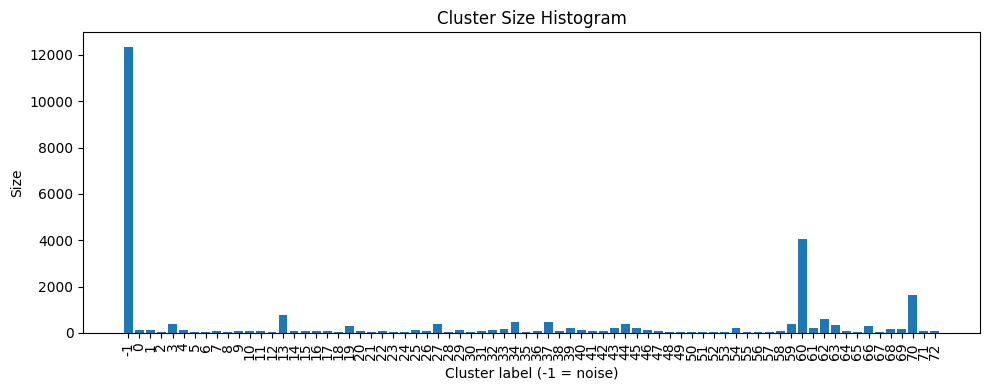

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, davies_bouldin_score
from collections import Counter
import numpy as np

# Use non-noise points for clustering metrics
mask = labels >= 0
non_noise_vecs = email_vecs[mask]
non_noise_labels = labels[mask]
unique_clusters = np.unique(non_noise_labels)

print("Cluster metrics (noise excluded):")
if len(non_noise_vecs) > 1 and len(unique_clusters) > 1:
    sil = silhouette_score(non_noise_vecs, non_noise_labels, metric="cosine")
    dbi = davies_bouldin_score(non_noise_vecs, non_noise_labels)
    print(f"Silhouette score: {sil:.4f}")
    print(f"Davies-Bouldin index: {dbi:.4f}")
else:
    print("Not enough clusters/samples to compute Silhouette/DBI.")

# Cluster size histogram (including noise)
cluster_sizes = Counter(labels)
cluster_ids = sorted(cluster_sizes.keys())
sizes = [cluster_sizes[c] for c in cluster_ids]

plt.figure(figsize=(10,4))
plt.bar([str(c) for c in cluster_ids], sizes)
plt.xticks(rotation=90)
plt.xlabel('Cluster label (-1 = noise)')
plt.ylabel('Size')
plt.title('Cluster Size Histogram')
plt.tight_layout()
plt.show()


In [9]:

# HDBSCAN on raw email embeddings loaded from the graph + silhouette score
import sys
from pathlib import Path
import numpy as np
try:
    import hdbscan  # pip install hdbscan
except ImportError as e:
    raise ImportError("Please install hdbscan (pip install hdbscan)") from e
from sklearn.metrics import silhouette_score

# Ensure src is on path
cwd = Path.cwd().resolve()
repo_root = cwd if (cwd / "core/GNN/src").exists() else cwd.parent
src_path = repo_root / "core/GNN/src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from src.load_graph_data import load_hetero_pt  # noqa: E402

# Load graph and extract raw email features
data = load_hetero_pt()
raw_emb = data["email"].x

if "torch" in globals() and isinstance(raw_emb, torch.Tensor):
    raw_np = raw_emb.detach().cpu().numpy()
else:
    raw_np = np.asarray(raw_emb)

clusterer = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=10, metric="euclidean")
labels = clusterer.fit_predict(raw_np)
noise = int((labels == -1).sum())
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Silhouette on non-noise clusters only
valid = labels != -1
if num_clusters > 1 and valid.sum() > num_clusters:
    sil = silhouette_score(raw_np[valid], labels[valid])
else:
    sil = float("nan")

print(f"HDBSCAN on raw email embeddings -> clusters: {num_clusters}, noise: {noise}, silhouette: {sil:.4f}")


/Users/mcandersyo/ITU/Research Project/GNN-Campaign-Detection/core/GNN/src/load_graph_data.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(path, map_l

HDBSCAN on raw email embeddings -> clusters: 206, noise: 17038, silhouette: 0.4403


In [7]:
import textwrap
import pandas as pd
from pathlib import Path

def _resolve_csv_id(node_idx):
    meta_i = email_meta[node_idx] if node_idx < len(email_meta) else {}
    csv_id = meta_i.get('orig_csv_index') if isinstance(meta_i, dict) else None
    if csv_id is None and isinstance(meta_i, dict):
        csv_id = meta_i.get('email_index', meta_i.get('index'))
    em = email_records[node_idx] if node_idx < len(email_records) else {}
    if csv_id is None and isinstance(em, dict):
        csv_id = em.get('orig_csv_index', em.get('email_index'))
    return int(csv_id) if csv_id is not None else None

def _print_email(node_idx, wrap_width=100, max_chars=1200):
    em = email_records[node_idx] if node_idx < len(email_records) else {}
    csv_id = _resolve_csv_id(node_idx)
    subj = (em.get('subject') or '').strip()
    body_clean = (em.get('body') or '').strip()
    body_clean = ' '.join(body_clean.split())
    body_snip = body_clean if len(body_clean) <= max_chars else body_clean[:max_chars] + '...'
    body_snip = textwrap.fill(body_snip, width=wrap_width)
    sender = em.get('sender') or ''
    receivers = ', '.join(em.get('receivers') or [])
    urls = em.get('urls') or []
    print('-' * 80)
    print(f'email_node_id={node_idx} | csv_row_id={csv_id}')
    print(f'sender   : {sender}')
    print(f'receivers: {receivers}')
    print(f'subject  : {subj}')
    print('body     :')
    print(body_snip)
    if urls:
        tail = ' ...' if len(urls) > 3 else ''
        print(f'urls     : {urls[:3]}{tail}')
    if csv_id is not None and 0 <= csv_id < len(df_csv):
        row = df_csv.iloc[csv_id]
        preview_cols = [c for c in ['label', 'sender', 'receiver', 'subject'] if c in df_csv.columns]
        preview = {c: row[c] for c in preview_cols}
        print(f'csv row preview: {preview}')
    elif csv_id is not None:
        print(f'(csv_row_id {csv_id} out of bounds for current CSV of length {len(df_csv)})')

def show_same_campaign_pair(row_idx=0):
    """Display the two emails from pair_votes_all.csv with vote == 'same_campaign'."""
    pair_votes_path = REPO_ROOT / 'core' / 'GNN' / 'notebooks' / 'pair_votes_all.csv'
    df_pairs = pd.read_csv(pair_votes_path)
    df_same = df_pairs[df_pairs['vote'] == 'same_campaign']
    if df_same.empty:
        print('No rows with vote == same_campaign found.')
        return
    row_idx = int(row_idx)
    if not 0 <= row_idx < len(df_same):
        print(f'row_idx {row_idx} out of bounds for {len(df_same)} same_campaign rows')
        return
    row = df_same.iloc[row_idx]
    a_id = int(row['email_a_id'])
    b_id = int(row['email_b_id'])
    print(f"same_campaign row {row_idx}: pair_id={row.get('pair_id')}, strategy={row.get('strategy')}, clusters=({row.get('cluster_a')}, {row.get('cluster_b')})")
    _print_email(a_id)
    _print_email(b_id)

# Example: show the first same_campaign pair
show_same_campaign_pair(2)


same_campaign row 2: pair_id=c1d756fd-2533-4c3f-b137-b1eafab95c88, strategy=same_cluster_random, clusters=(47.0, 47.0)
--------------------------------------------------------------------------------
email_node_id=7838 | csv_row_id=7838
sender   : latitudeszagreb@mailup.net
receivers: ktwarwic@speedy.uwaterloo.ca
subject  : High Quality Rolex Replica Watches!
body     :
VIP ������ R_E_P_L_I_C_A �������W_A_T_C_H_E_S! If you are looking for a stylish, quality costume
watch at low prices, our offers are for you. We specialize in top quality replica watches. Wearing
these expensive looking watches is prestigious. Buying these models you will save you a ton of money
and always look trendy. We offer a free gift box with every VIP watch ordered. You can use it as a
lovely gift for your friends or relatives or keep your gorgeous watch there. No matter what you do
with your watch, you will enjoy it. Check out our gift boxes that will make the present even more
glamorous. 7.-0>LS@0CC.3YA.5*
csv 